In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [5]:

# Load dataset
file_path = "nvidia_stock_prices.csv"
df = pd.read_csv(file_path)

In [6]:
df

,Date,Open,High,Low,Close,Volume
0,2004-01-02,0.196417,0.199083,0.192333,0.192333,436416000
1,2004-01-05,0.195250,0.199917,0.193500,0.198583,575292000
2,2004-01-06,0.198000,0.209417,0.197083,0.206667,1093344000
3,2004-01-07,0.204333,0.209500,0.202917,0.208500,673032000
4,2004-01-08,0.211083,0.212083,0.207250,0.209250,433752000
...,...,...,...,...,...,...
5028,2023-12-22,49.195000,49.382999,48.466999,48.830002,252507000
5029,2023-12-26,48.967999,49.599998,48.959999,49.278999,244200000
5030,2023-12-27,49.511002,49.680000,49.084999,49.417000,233648000
5031,2023-12-28,49.643002,49.883999,49.411999,49.521999,246587000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5033 non-null   object 
 1   Open    5033 non-null   float64
 2   High    5033 non-null   float64
 3   Low     5033 non-null   float64
 4   Close   5033 non-null   float64
 5   Volume  5033 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 236.1+ KB


Epoch 1/13


c:\Users\ACM\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 4.1109e-04 - val_loss: 0.0049
Epoch 2/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.4189e-05 - val_loss: 0.0045
Epoch 3/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.1744e-05 - val_loss: 0.0041
Epoch 4/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.8876e-05 - val_loss: 0.0018
Epoch 5/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.5881e-05 - val_loss: 0.0029
Epoch 6/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.5310e-05 - val_loss: 0.0054
Epoch 7/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6782e-05 - val_loss: 0.0032
Epoch 8/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.5987e-05 - val_loss: 0.0027
Epoch 9/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.5256e-05 - val_loss: 0.0064
Epoch 10/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.4098e-05 - val_loss: 0.0027
Epoch 11/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.5497e-05 - val_loss: 0.0053
Epoch 12

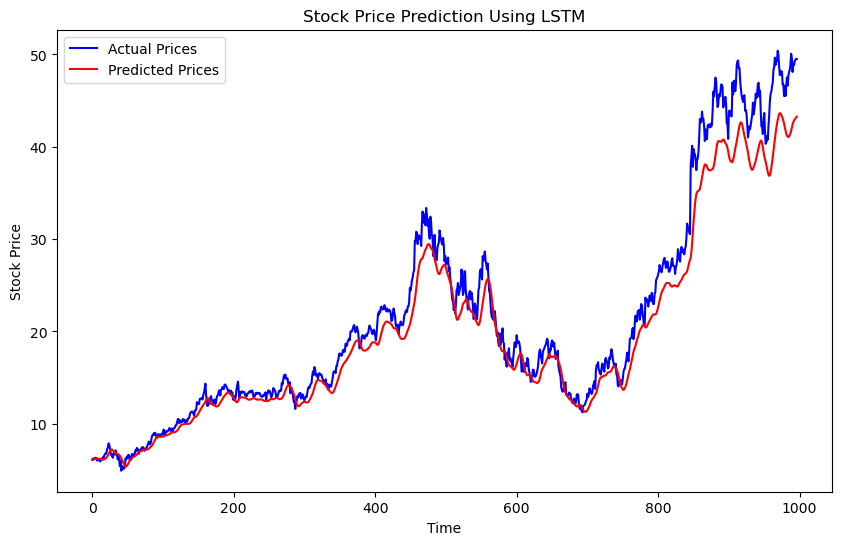

In [8]:

#  Convert Date to datetime format (if applicable)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

#  Use only "Close" price for prediction
data = df[['Close']].values

#  Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

#  Create sequences for LSTM (Sliding Window)s

def create_sequences(data, time_steps=50):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 50  # Past 50 days data to predict next day 
X, y = create_sequences(data_scaled, time_steps)

#  Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#  Build LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, 1)),  
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer (Predicting "Close" price)
])

#  Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#  Train the model
history = model.fit(X_train, y_train, epochs=13, batch_size=32, validation_data=(X_test, y_test), verbose=1)

#  Make predictions
y_pred = model.predict(X_test)

#  Convert predictions back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

#  Evaluate the model
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")

#  Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label="Actual Prices", color='blue')
plt.plot(y_pred_actual, label="Predicted Prices", color='red')
plt.legend()
plt.title("Stock Price Prediction Using LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()


In [9]:
data_scaled

array([[0.00226006],
       [0.00238424],
       [0.00254486],
       ...,
       [0.98029024],
       [0.98237644],
       [0.98237644]])

In [10]:
print(X)

[[[0.00226006]
  [0.00238424]
  [0.00254486]
  ...
  [0.00188256]
  [0.00195542]
  [0.00187594]]

 [[0.00238424]
  [0.00254486]
  [0.00258128]
  ...
  [0.00195542]
  [0.00187594]
  [0.00202331]]

 [[0.00254486]
  [0.00258128]
  [0.00259618]
  ...
  [0.00187594]
  [0.00202331]
  [0.00211105]]

 ...

 [[0.91428644]
  [0.87142962]
  [0.83681834]
  ...
  [0.97180634]
  [0.96862735]
  [0.97754835]]

 [[0.87142962]
  [0.83681834]
  [0.83493086]
  ...
  [0.96862735]
  [0.97754835]
  [0.98029024]]

 [[0.83681834]
  [0.83493086]
  [0.82074459]
  ...
  [0.97754835]
  [0.98029024]
  [0.98237644]]]


In [11]:
X.shape

(4983, 50, 1)

In [12]:
print(y)

[[0.00202331]
 [0.00211105]
 [0.00215246]
 ...
 [0.98029024]
 [0.98237644]
 [0.98237644]]


In [13]:
y.shape

(4983, 1)

In [14]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [15]:
data =df[['Close']].values
data
print(type(data))

<class 'numpy.ndarray'>
